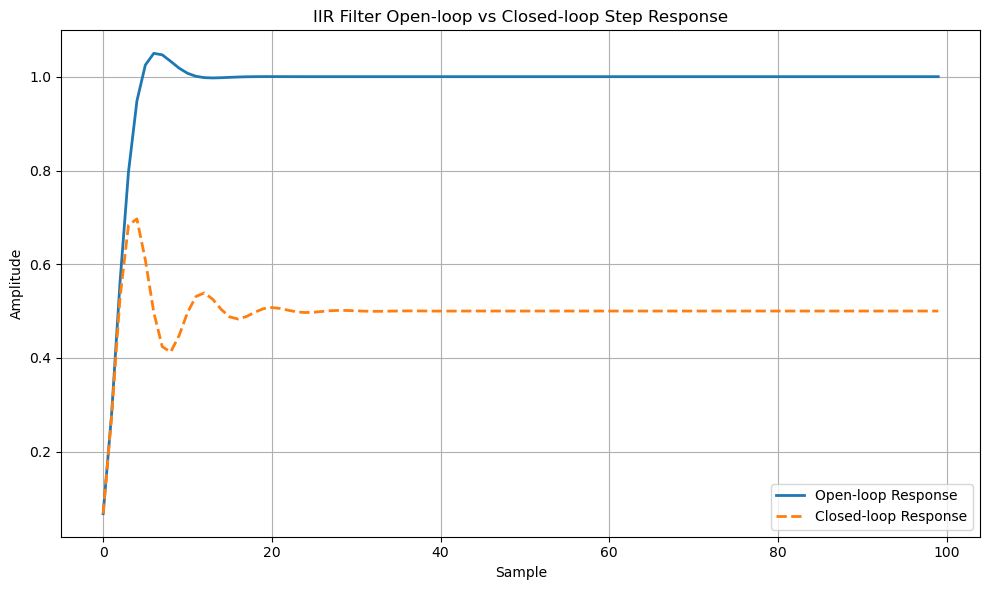

In [6]:


import matplotlib.pyplot as plt
import numpy as np

# IIR Filter parameters
b = [0.0675, 0.1349, 0.0675]       # numerator coefficients (b0, b1, b2)
a = [1.0, -1.14298, 0.41280]       # denominator coefficients (1, a1, a2)

# Create the IIR filter function (same structure as your C code)
def iir_filter(input_signal):
    x = [0.0, 0.0, 0.0]  # input history
    y = [0.0, 0.0, 0.0]  # output history
    output = []

    for n in range(len(input_signal)):
        x[2] = x[1]
        x[1] = x[0]
        x[0] = input_signal[n]

        y[2] = y[1]
        y[1] = y[0]

        y[0] = b[0]*x[0] + b[1]*x[1] + b[2]*x[2] - a[1]*y[1] - a[2]*y[2]
        output.append(y[0])

    return np.array(output)

# Open-loop response: Step input
n_samples = 100
step_input = np.ones(n_samples)
open_loop_response = iir_filter(step_input)

# Closed-loop response: Unity feedback (y[n] = output - feedback)
def closed_loop_iir(input_signal):
    x = [0.0, 0.0, 0.0]  # input history
    y = [0.0, 0.0, 0.0]  # output history
    output = []

    for n in range(len(input_signal)):
        x[2] = x[1]
        x[1] = x[0]
        x[0] = input_signal[n] - y[0]  # feedback from previous output

        y[2] = y[1]
        y[1] = y[0]

        y[0] = b[0]*x[0] + b[1]*x[1] + b[2]*x[2] - a[1]*y[1] - a[2]*y[2]
        output.append(y[0])

    return np.array(output)

closed_loop_response = closed_loop_iir(step_input)

# Plot both responses
plt.figure(figsize=(10, 6))
plt.plot(open_loop_response, label='Open-loop Response', linewidth=2)
plt.plot(closed_loop_response, label='Closed-loop Response', linewidth=2, linestyle='--')
plt.title('IIR Filter Open-loop vs Closed-loop Step Response')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

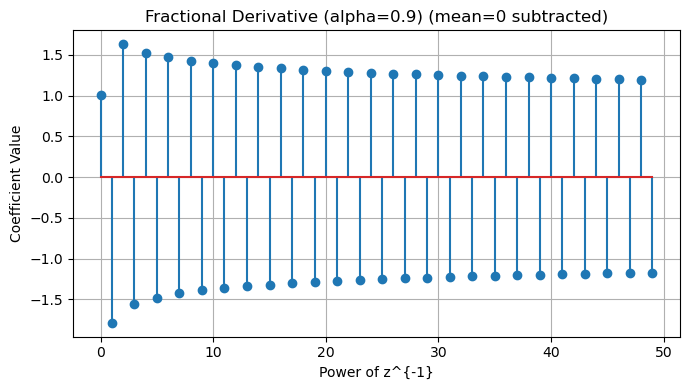

[INFO] Wrote 50 Derivative coeffs to frac_derivative_coeffs_vhdl.txt (mean=0 subtracted).


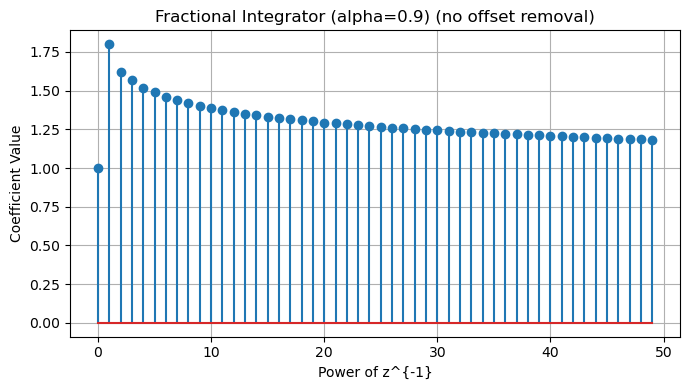

[INFO] Wrote 50 Integrator coeffs to frac_integrator_coeffs_vhdl.txt (no offset removal).


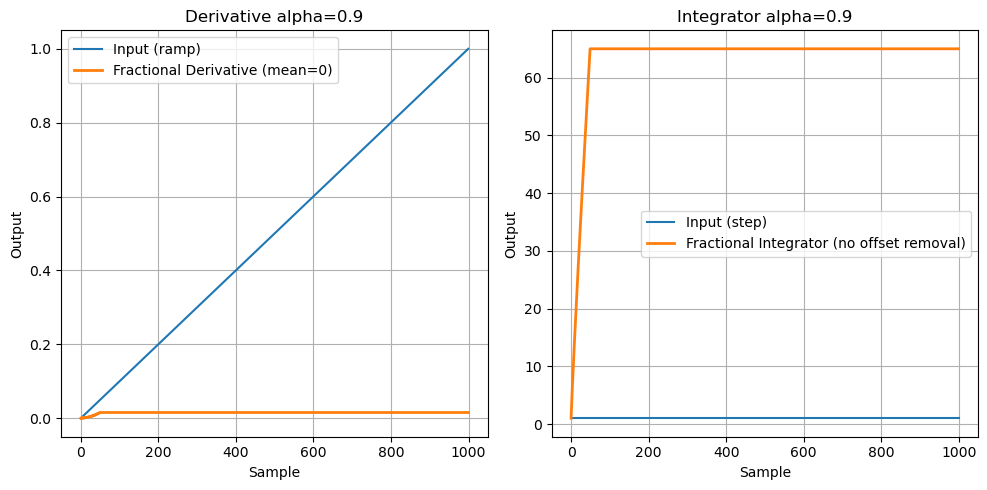

In [25]:
import sympy
import numpy as np
import matplotlib.pyplot as plt

def fractional_tustin_series(alpha=0.5, is_derivative=True, order=50):
    """
    Builds a truncated polynomial expansion of a fractional operator via Tustin.
    - If is_derivative=True, we do H(s) = s^(+alpha) (fractional derivative).
    - If is_derivative=False, we do H(s) = s^(-alpha) (fractional integrator).

    The expression is expanded in powers of w (z^-1), but we only retain 
    integer exponents. Fractional exponents are discarded.

    Returns a list of float coefficients in ascending powers of w:
        c0 + c1*w^1 + c2*w^2 + ...
    """
    s = sympy.Symbol('s', complex=True)
    z = sympy.Symbol('z', complex=True)
    w = sympy.Symbol('w', complex=True)

    # Tustin (bilinear) transform: s -> (1 - z^-1)/(1 + z^-1)
    s_to_z = (1 - z**(-1)) / (1 + z**(-1))

    # Fractional operator: derivative => s^(+alpha), integrator => s^(-alpha)
    sign = +1 if is_derivative else -1
    H_s = s**(sign * alpha)

    # Substitute Tustin => H(z), then rewrite in w = z^-1
    H_z = H_s.subs(s, s_to_z).simplify()
    H_w = H_z.subs(z, 1/w)

    # Series expansion around w=0 up to 'order' terms
    series_expr = sympy.series(H_w, w, 0, order).removeO()

    # Parse the sum of monomials, skipping fractional exponents
    terms = sympy.Add.make_args(series_expr)
    result_dict = {}  # exponent -> coefficient (accumulated)

    for term in terms:
        factor_map = term.as_powers_dict()
        if w not in factor_map:
            exponent = 0.0
        else:
            exponent = float(factor_map[w])

        # Isolate coefficient
        if exponent != 0.0:
            coeff = term / (w**exponent)
        else:
            coeff = term

        # Keep it only if exponent is an integer
        rounded_exp = int(round(exponent))
        if abs(exponent - rounded_exp) < 1e-10:
            if rounded_exp not in result_dict:
                result_dict[rounded_exp] = 0
            result_dict[rounded_exp] += coeff
        # else: skip fractional exponent

    # Build ascending list of coefficients
    if result_dict:
        max_exp = max(result_dict.keys())
    else:
        max_exp = 0

    out_coeffs = []
    for e in range(max_exp + 1):
        val = sympy.simplify(result_dict.get(e, 0))
        out_coeffs.append(float(val.evalf()))

    return out_coeffs

def generate_fractional_operator_coeffs(
    alpha=0.5, 
    is_derivative=True,
    order=50, 
    Q=15, 
    vhdl_filename='fractional_operator_scaled_coeffs_vhdl.txt'
):
    """
    Creates a truncated polynomial approximation for either:
      - fractional derivative (H(s) = s^alpha), with mean=0
      - fractional integrator (H(s) = s^-alpha), with no offset removal
    using Tustin's method, discarding fractional exponents.

    1) Symbolic expansion up to 'order' terms
    2) If derivative: subtract mean so the average of coeffs = 0
    3) Scale by 2^Q
    4) Writes a VHDL array to 'vhdl_filename'
    5) Returns scaled_coeffs as a Python list of int
    """
    # 1) Derive truncated polynomial
    coeffs = fractional_tustin_series(alpha=alpha, is_derivative=is_derivative, order=order)

    # 2) Force mean=0 only for derivatives
    deriv_or_integ = 'Derivative' if is_derivative else 'Integrator'
    if is_derivative:
        mean_c = np.mean(coeffs)
        coeffs = [c - mean_c for c in coeffs]
        note = '(mean=0 subtracted)'
    else:
        note = '(no offset removal)'

    # Plot them
    plt.figure(figsize=(7,4))
    plt.stem(range(len(coeffs)), coeffs)
    plt.title(f'Fractional {deriv_or_integ} (alpha={alpha}) {note}')
    plt.xlabel('Power of z^{-1}')
    plt.ylabel('Coefficient Value')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 3) Scale by 2^Q => integer representation
    scaled_coeffs = [int(round(c * (2**Q))) for c in coeffs]

    # 4) Write to VHDL
    with open(vhdl_filename, 'w') as f:
        L = len(scaled_coeffs)
        f.write(f'type coefficients is array (0 to {L-1}) of signed({Q} downto 0);\n')
        f.write('signal coeff_s: coefficients := (\n')
        
        for i, val in enumerate(scaled_coeffs):
            hex_val = f'x"{val & 0xFFFF:04X}"'
            sep = ',' if i < L-1 else ''
            f.write(f'{hex_val}{sep} ')

            if ((i+1) % 6 == 0) and (i < L-1):
                f.write('\n')
        f.write(');\n')

    print(f'[INFO] Wrote {len(scaled_coeffs)} {deriv_or_integ} coeffs to {vhdl_filename} {note}.')
    return scaled_coeffs

def fractional_fir_filter(u, scaled_coeffs, Q=15):
    """
    Simple FIR filter:
        y[n] = sum_{k=0 to N-1}[ (scaled_coeffs[k]/2^Q) * u[n-k] ],
    ignoring any n-k < 0 terms (zero-pad).
    """
    N = len(scaled_coeffs)
    out = np.zeros_like(u, dtype=float)

    for n in range(len(u)):
        acc = 0.0
        for k in range(N):
            if n - k >= 0:
                coeff_float = scaled_coeffs[k] / (2**Q)
                acc += coeff_float * u[n - k]
        out[n] = acc
    return out

# ------------------------------------------------------------------------
# Example usage:
# ------------------------------------------------------------------------
if __name__ == '__main__':
    alpha_deriv = 0.9
    alpha_integ = 0.9
    order = 50
    Q = 15

    # Fractional derivative: subtract mean
    deriv_file = 'frac_derivative_coeffs_vhdl.txt'
    d_coeffs = generate_fractional_operator_coeffs(alpha=alpha_deriv, is_derivative=True,
                                                   order=order, Q=Q, vhdl_filename=deriv_file)

    # Fractional integrator: keep offset
    integ_file = 'frac_integrator_coeffs_vhdl.txt'
    i_coeffs = generate_fractional_operator_coeffs(alpha=alpha_integ, is_derivative=False,
                                                   order=order, Q=Q, vhdl_filename=integ_file)

    # Test signals
    N_samples = 1000
    ramp_input = np.linspace(0, 1, N_samples)  # for derivative
    step_input = np.ones(N_samples)            # for integrator

    d_out = fractional_fir_filter(ramp_input, d_coeffs, Q=Q)
    i_out = fractional_fir_filter(step_input, i_coeffs, Q=Q)

    # Plot responses
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.plot(ramp_input, label='Input (ramp)')
    plt.plot(d_out, label='Fractional Derivative (mean=0)', linewidth=2)
    plt.title(f'Derivative alpha={alpha_deriv}')
    plt.xlabel('Sample')
    plt.ylabel('Output')
    plt.grid(True)
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(step_input, label='Input (step)')
    plt.plot(i_out, label='Fractional Integrator (no offset removal)', linewidth=2)
    plt.title(f'Integrator alpha={alpha_integ}')
    plt.xlabel('Sample')
    plt.ylabel('Output')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
import sympy
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ------------------------------------------------------------------------------
# 1) IIR Filter (Plant)
# ------------------------------------------------------------------------------
class IIRPlant:
    """
    A second-order IIR plant, updated sample-by-sample:
      y[n] = b0*x[n] + b1*x[n-1] + b2*x[n-2] - a1*y[n-1] - a2*y[n-2].
    """
    def __init__(self, b, a):
        """
        b: [b0, b1, b2]
        a: [1, a1, a2]   # The first '1' is the y[n] coefficient
        """
        self.b = b
        self.a = a
        self.reset()

    def reset(self):
        self.x_hist = [0.0, 0.0]  # x[n-1], x[n-2]
        self.y_hist = [0.0, 0.0]  # y[n-1], y[n-2]

    def step(self, x_new):
        b0, b1, b2 = self.b
        a1, a2 = self.a[1], self.a[2]

        x0 = x_new
        x1 = self.x_hist[0]
        y1 = self.y_hist[0]
        y2 = self.y_hist[1]

        # Output
        y0 = b0*x0 + b1*x1 + b2*self.x_hist[1] - a1*y1 - a2*y2

        # Shift history
        self.x_hist = [x0, x1]
        self.y_hist = [y0, y1]
        return y0


# ------------------------------------------------------------------------------
# 2) Fractional Operators via Tustin expansions
# ------------------------------------------------------------------------------
def fractional_tustin_series(alpha=0.5, is_derivative=True, order=50):
    """
    Symbolically build truncated polynomial for s^(±alpha) under Tustin.
    Discards fractional exponents in w. Returns ascending coeff array:
      c0 + c1*w^1 + c2*w^2 + ...
    """
    import sympy
    s = sympy.Symbol('s', complex=True)
    z = sympy.Symbol('z', complex=True)
    w = sympy.Symbol('w', complex=True)

    # Tustin
    s_to_z = (1 - z**(-1)) / (1 + z**(-1))

    # Derivative => s^+alpha, Integrator => s^-alpha
    sign = +1 if is_derivative else -1
    H_s = s**(sign * alpha)

    # s->z->w
    H_z = H_s.subs(s, s_to_z).simplify()
    H_w = H_z.subs(z, 1/w)

    # Series expansion around w=0 up to 'order' terms
    series_expr = sympy.series(H_w, w, 0, order).removeO()
    terms = sympy.Add.make_args(series_expr)
    result_dict = {}

    for term in terms:
        factor_map = term.as_powers_dict()
        exponent = float(factor_map.get(w, 0))
        coeff = term/(w**exponent) if exponent!=0 else term

        # Keep only integer exponents
        e_rounded = int(round(exponent))
        if abs(exponent - e_rounded) < 1e-10:
            result_dict[e_rounded] = result_dict.get(e_rounded,0) + coeff

    # Build ascending list
    if result_dict:
        max_exp = max(result_dict.keys())
    else:
        max_exp = 0

    out_coeffs = []
    for e in range(max_exp+1):
        val = sympy.simplify(result_dict.get(e, 0))
        out_coeffs.append(float(val.evalf()))
    return out_coeffs

def generate_fractional_operator_coeffs(alpha=0.5, is_derivative=True, order=50, Q=15):
    """
    1) Get polynomial from fractional_tustin_series(alpha,...).
    2) If derivative => remove mean => zero DC offset.
    3) Scale by 2^Q => integer taps.
    """
    coeffs = fractional_tustin_series(alpha=alpha, is_derivative=is_derivative, order=order)

    # For derivative, ensure zero DC
    if is_derivative:
        m = np.mean(coeffs)
        coeffs = [c - m for c in coeffs]

    scaled = [int(round(c*(2**Q))) for c in coeffs]
    return scaled

class FractionalFIR:
    """
    A sample-by-sample fractional FIR (for integrator or derivative).
    Taps in Q-format => multiply by (taps[i]/2^Q).
    """
    def __init__(self, taps, Q=15):
        self.taps = taps
        self.Q = Q
        self.N = len(taps)
        self.buffer = [0.0]*self.N

    def reset(self):
        for i in range(self.N):
            self.buffer[i] = 0.0

    def step(self, x_new):
        # shift
        for i in reversed(range(1, self.N)):
            self.buffer[i] = self.buffer[i-1]
        self.buffer[0] = x_new

        # dot product
        acc = 0.0
        for k, val in enumerate(self.buffer):
            acc += (self.taps[k]/(2**self.Q)) * val
        return acc


# ------------------------------------------------------------------------------
# 3) FOPID Controller + closed-loop simulation
# ------------------------------------------------------------------------------
def closed_loop_fopid(plant, N=200, Kp=0.5, Ki=0.1, Kd=0.1, 
                      alpha_integ=0.9, alpha_deriv=0.9, order=50, Q=15):
    """
    We build fractional integrator & derivative from alpha_integ/alpha_deriv,
    then run a step-response with unity feedback.
    
      u[n] = Kp*e[n] + Ki * (I_{alpha_integ}( e[n] )) + Kd * (D_{alpha_deriv}( e[n] ))
      e[n] = r[n] - y[n], r=1 step.
    """
    # Generate taps fresh each time, so alpha_integ, alpha_deriv are dynamic
    i_taps = generate_fractional_operator_coeffs(alpha=alpha_integ, is_derivative=False,
                                                 order=order, Q=Q)
    d_taps = generate_fractional_operator_coeffs(alpha=alpha_deriv, is_derivative=True,
                                                 order=order, Q=Q)

    i_fir = FractionalFIR(i_taps, Q=Q)
    d_fir = FractionalFIR(d_taps, Q=Q)
    i_fir.reset()
    d_fir.reset()

    plant.reset()

    r = np.ones(N)
    y = np.zeros(N)
    e = np.zeros(N)
    u = np.zeros(N)

    for n in range(N):
        e[n] = r[n] - (y[n-1] if n>0 else 0.0)
        i_val = i_fir.step(e[n])
        d_val = d_fir.step(e[n])
        u[n] = Kp*e[n] + Ki*i_val + Kd*d_val

        y[n] = plant.step(u[n])

    t = np.arange(N)
    return t, r, u, y, e

def cost_function(params, plant, N=200, order=50, Q=15):
    """
    Minimizes SSE on a step response with FOPID parameters:
      [Kp, Ki, Kd, alpha_integ, alpha_deriv].
    We penalize negative gains or negative alpha.
    """
    Kp, Ki, Kd, alpha_i, alpha_d = params

    # Basic constraints: no negative gains, alpha>0, etc.
    if (Kp < 0) or (Ki < 0) or (Kd < 0) or (alpha_i <= 0) or (alpha_d <= 0):
        return 1e9  # large penalty

    # If you want upper bound on alpha, e.g. alpha_i < 2.0, alpha_d < 2.0
    # then if alpha_i>2 or alpha_d>2 => also penalty. Adjust as you like.

    _, r, _, y, _ = closed_loop_fopid(plant, N=N,
                                      Kp=Kp, Ki=Ki, Kd=Kd,
                                      alpha_integ=alpha_i,
                                      alpha_deriv=alpha_d,
                                      order=order, Q=Q)

    sse = np.sum((r - y)**2)
    return sse


# ------------------------------------------------------------------------------
# 4) Demo / main: Optimize [Kp, Ki, Kd, alpha_integ, alpha_deriv]
# ------------------------------------------------------------------------------
if __name__ == '__main__':
    # Build IIR plant with your coefficients
    b_plant = [0.0675, 0.1349, 0.0675]
    a_plant = [1.0, -1.14298, 0.41280]
    plant = IIRPlant(b_plant, a_plant)

    # We will do a step response of length N=300 for cost
    N = 300
    Q = 15
    order = 50

    # Initial guess: Kp, Ki, Kd, alpha_integ, alpha_deriv
    init_guess = [0.5, 0.1, 0.1, 0.9, 0.9]

    # Use scipy.optimize
    from functools import partial
    cost_fn = partial(cost_function, plant=plant, N=N, order=order, Q=Q)

    from scipy.optimize import minimize
    result = minimize(cost_fn, init_guess, method='Nelder-Mead')
    best_params = result.x
    Kp_opt, Ki_opt, Kd_opt, alpha_i_opt, alpha_d_opt = best_params

    print('Optimization complete.')
    print('Best parameters:')
    print(f'  Kp         = {Kp_opt:.4f}')
    print(f'  Ki         = {Ki_opt:.4f}')
    print(f'  Kd         = {Kd_opt:.4f}')
    print(f'  alpha_integ= {alpha_i_opt:.4f}')
    print(f'  alpha_deriv= {alpha_d_opt:.4f}')
    print('Final SSE:', result.fun)

    # Final simulation with the best parameters
    t, r, u, y, e = closed_loop_fopid(plant, N=400,
                                      Kp=Kp_opt, Ki=Ki_opt, Kd=Kd_opt,
                                      alpha_integ=alpha_i_opt,
                                      alpha_deriv=alpha_d_opt,
                                      order=order, Q=Q)

    # Plot
    plt.figure(figsize=(10,6))
    plt.subplot(2,1,1)
    plt.plot(t, r, label='Reference')
    plt.plot(t, y, label='Plant Output')
    plt.ylabel('Amplitude')
    plt.title('FOPID Closed-Loop Step Response (Optimized Gains + Alpha)')
    plt.grid(True)
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(t, u, label='Control (u[n])')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()
